# Learning with a Wasserstein Loss

Stochastic Optimization and Automatic Differentiation for Machine Learning (Spring 2018), Marco Cuturi <br>
http://marcocuturi.net/soadml.html <br>

Project Report (due May 16th, by email) - Raphael Huille, ENSAE

 - Disponible sur Github : 

https://github.com/rhuille/ENSAE-homework/blob/master/GMML%20project/Studying%20Time%20Series%20using%20Dynamic%20Time%20Warping.ipynb


 - Ou Jupyter Nbviewer : 

http://nbviewer.jupyter.org/github/rhuille/ENSAE-homework/blob/master/GMML%20project/Studying%20Time%20Series%20using%20Dynamic%20Time%20Warping.ipynb



** Table of Content **

I. [Formalisation](#I---Formalisation)
 1. [The problem](#I.1---The-problem)
 2. [The model](#I.2---The-model)
 3. [The loss function](#I.3---The-loss-function)
    
II. [Implementation of the predictor](#II---Implementation)
 1. [Class predictor](#II.1---Class-predictor)
 2. [Test on a simulated dataset](#II.2-Test-on-a-simulated-dataset)
    
III. [Application on Iris dataset](#III---Iris-dataset) 
1. [Cheking the good running of the algo](#III.1---Cheking-the-good-running-of-the-algo)
2. [Comparing predictions](#III.2---Comparing-predictions)
3. [Changing the ground metric](#III.3---Changing-the-ground-metric)

[Take home message](#Take-home-message)

## I - Formalisation
-----------
#### I.1 - The problem

In the usual setting of statistical learning, $X \in \mathbb{R}^p$ are the features and $y$ is the label.

Consider a set of classes $\{ 1, 2, ..., K \}$ and $y$ can belong to several classes at the same time. This is a multi-label classification which can be formalised as follow :
$$ y = F(y_{\hbox{score}})$$<br>
$$ y_{\hbox{score}} \in \{ e\in [0,1]^K ; \quad ||e||_1 ⁼ 1 \} $$ <br>

The $j$th coordinate of $y_{\hbox{score}}$ would be a score interpretable as the probability that $y$ belong to the $j$ th class.

$F$ is a function which choose the classes according to scores :
- If you want a fix number of classes k,  you could take : $F =$ the k-best score. 
- If you do not want a fix number of classes, $F$ can choose the best scores until some gap value between scores.

For example, if $K=3$ and $y_{\hbox{score}} = (0.5, 0.4, 0.1)$ then we could say that the target is only in class $1$ (if you want only 1 class), but we could also say that the target is in both class $1$ and $2$. Of course the choice of the function $F$ depends on the situation.

In the third section I will use the iris dataset. In this context, $K = 3$ and each flower belongs to only $1$ class : $F$ will simply be the *argmax* function (the $1$-best score ).


#### I.2 - The model

We are considering a logistic model - this is the last layer in a neural network :

$$ y_{\hbox{score}} = h( X \cdot \theta ) + \varepsilon $$

With : $ y_{\hbox{score}} \in \mathbb{M}_{1xK}  \quad X\in \mathbb{M}_{1xp} \quad \theta \in \mathbb{M}_{pxK} \quad \varepsilon \in  \mathbb{M}_{1xK} $<br>
and : 

$$ \forall z \in \mathbb{M}_{1xK} \quad  h(z) = (h_1(z), h_2(z), ..., h_K(z)) $$

$$ \forall z \in \mathbb{M}_{1xK} \quad h_k(z) = \dfrac{e^{z_k}}{\sum_j^K e^{z_j}} $$


$h$ is called the softmax function.

It is important to notice that the fact $\sum_j^K h_j(z) = 1$ makes the columns of $\theta$ linked and the parameters is not uniquely identifiable. Nothing to worry about, we could just fix a column equal to $0$. In the binary logistic model this is what is done as :
$$P(Y = 1 \ | X) =  \dfrac{e^{X \cdot \theta_1}}{e^{X \cdot \theta_1}+e^{X \cdot \theta_2}} =  \dfrac{e^{X \cdot \theta_1}}{e^{X \cdot \theta_1}+1} \quad P(Y = 0 \ | X) =  \dfrac{1}{e^{- X \cdot \theta_1}+1} $$


#### I.3 - The loss function

To compute the $\theta$ optimal, which we call $\theta^*$, we need a loss function to minimize. 

** Logistic ** <br>
In the traditional logistic regression, we minimize the *- log likelihood* :

$$ - \hbox{log}\mathcal{L}(\theta) = - \sum_i^n \sum_k^K 1\{ y_i = k \} ( X_i \cdot \theta_k  -\hbox{log}( \sum_j^K e^{X_i \cdot \theta_j} ) )  \ $$

The gradient is easy to compute. It is the sum of the gradrient of each term in the sum :

$$ - \nabla \hbox{log}\mathcal{L}_i(\theta) = X_i^T ( h(X_i \cdot \theta) - (1\{ y_i = k \})_{k = 1... K} ) $$

I will use this formula in the gradient descent below.<br>
*NB : The gradient is of size $pxK$ because $\theta$ is of size $pxK$.*


Few comments : 
- Here we are using the label $y$, not $y_{\hbox{score}}$
- Minimizing $- \hbox{log}\mathcal{L}$ is the same as minimizing the Kullback–Leibler divergence from $P_{\theta}$ to $P_{\theta^*}$ : 
$$ \sum_i^n \hbox{log}(P_{\theta^*}(Y_i, X_i)) - \hbox{log}\mathcal{L}(\theta) = \sum_i^n \hbox{log}(\dfrac{P_{\theta^*}(Y_i, X_i)}{P_{\theta}(Y_i, X_i)}) \approx \mathbb{E}_{\theta^*} \ \hbox{log}(\dfrac{P_{\theta^*}(Y_i, X_i)}{P_{\theta}(Y_i, X_i)}) = \mathcal{KL}(P_{\theta^*} \ || \ P_{\theta})$$
And the approximation becomes an equality as $ n \rightarrow \infty $.

** Wasserstein ** <br>
The paper proposes to consider the Wasserstein distance between $h(X \cdot \theta)$, the predicted distribution over classes and $ y_{\hbox{score}}$ the observed distribution over classes. Given a "ground metrix", a distance between classes given a $K x K$ matrix $M$ ($m_{ij}$ is the distance between class $i$ and class $j$), the Wassertstein distance can be defined has :

$$W(\mu, \nu) = \hbox{min} \{ \sum_{i, j \in 1...K } t_{ij} m_{ij} \ ; \ \sum_j t_{ij} = \mu_i \ \sum_i t_{ij} = \nu_j  \} $$


We want to minimise :

$$ \mathcal{W}(\theta) = \sum_i W(h(X_i \cdot \theta), y_{\hbox{score}})  $$

The gradient of the $i$-th term of the sum can be express has : 

$$ \nabla_{\theta} W(h(X_i \cdot \theta), y_{\hbox{score}}) = \nabla_{h(X_i \cdot \theta)} W(h(X_i \cdot \theta), y_{\hbox{score}})  \times \nabla_{\theta}h(X_i \cdot \theta) $$

- $\nabla_{\theta}h(X_i \cdot \theta)$ is easy to compute. <br>
Cf. method *H_gradient_computation* in the *predictor* class below.


- $\nabla_{h(X_i \cdot \theta)} W(h(X_i \cdot \theta), y_{\hbox{score}}) $ is more tricky and is explained in the paper - p.4 *Algorithm 1*. It involves entropic regularisation and Sinkhorn algorithm. <br>
Cf. method *Sinkorn_computation* in the *predictor* class below.


** Differences between the two loss functions**
- Computation of the gradient of  Wasserstein loss is more costly than the gradient of the Logistic loss.
- The Wasserstein loss focus on the distribution over classes considering a metric in the space of classes. This is particulaly interresting when the space of classes is complex. The example developped in the paper is especially relevant : when predicting word tags for pictures, the space of classes is a word embedding provided with a metric. The Wasserstein loss allows to take into account this metris in the prediction. A metrics over classes is usefull when you have similarities between class to introduce : when this is not to bad to predict $i$ instead of $j$ because $i$ is almost the same as $j$.
In the third section I try this method on the iris dataset which space of class is $\{0,1,2 \}$ which natural metris is simply $J_3 - I_3$... The three classes have no reason to be closer to one in particular. Using a Wasserstein loss in this context is not relevant.


## II - Implementation
-------
In this section I implement and test the predictors described in previous section. It uses gradient descent with both Logistic loss and Wasserstein loss.<br>
The algorithm is in the class *predictor* below. I will use this class all along this notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_iris
from matplotlib.colors import ListedColormap

%matplotlib inline

#### II.1 - Class predictor

In [2]:
class predictor:
    """
    Class predictor contain the implementation of algorithm 1 and 2 presented in the paper 
    "Learning with Wassertein loss"
    I will use this class all along this notebook. 
    Please, understand this object in order to understand the notebook.
    
    parameters
    ----------
    # 
    loss (str) : 'wasserstein' or 'logistic' 
    method (str) : 'gradient' (for a standard gradient descent) or 'sgd' (for a stochastic gradient descent) 
    #
    eta (float): step in gradient descent  - nb : eta is constant along iteration
    s (int): batch_size - only use when method = 'sgd'
    n_iter (int): number of iteration of gradient descent
    l (float): inverse of the weight of the entropic regularisation - nb : this is lambda in the paper
    M (np array KxK): ground_metric matrix (default : J_K - I_K) - only used when loss = 'wassertein'   
    #
    X (np array nxp) : feature matrix
    y (np array nxK): label matrix
    t (np array pxK): weight matrix - nb : this is theta in the Formalisation section above
    #
    K (int): number of classes
    n (int): number of observation
    p (int): dimension of the feature set  
    #
    self.t_list (np array n_iterxpxK): list of the weight matrix along iteration of gradient descent
    self.grad_list (np array n_iterxpxK): list of the gradient matrix along iteration of gradient descent
    
    methods
    -------
    train : compute the parameters with respect to the loss function and method
    predict : predict the y_score
    #
    train_wasserstein :
    train_logistic :
    #
    Sinkhorn_computation : 
    H_gradient_computation :
    batch_list_creator : 
    """
    
    def __init__(self, loss ='wasserstein', method = 'gradient', n_iter = 10,
                 batch_size = 10, eta = 0.01, ground_metric = None, 
                 lambda_ = 10, n_sinkhorn = 50, fit_intercept = True):
        
        self.loss = loss
        self.method = method
        
        # 
        self.eta = eta
        self.s = batch_size
        self.n_iter = n_iter
        self.l = lambda_
        self.M = ground_metric # have a default value
        self.n_sinkhorn = n_sinkhorn
        self.fit_intercept = fit_intercept
        
        # data
        self.X = None
        self.y = None
        self.t = None
        
        # size
        self.K = None
        self.n = None
        self.p = None
        
        # storage
        self.t_list = None
        self.grad_list = None

    # - not interesting - #
    def __str__(self):
        sb = []
        for key in self.__dict__:
            if key in ['X', 'y', 't', 'M', 't_list', 'grad_list']:
                continue
            sb.append("{key}='{value}'".format(key=key, value=self.__dict__[key]))
        return 'predictor (' + ', '.join(sb) + ')'
    
    def __repr__(self):
        return self.__str__()
    
    def methodp(self):
        if self.method == 'gradient':
            return 'Standart gradient descent'
        if self.method == 'sgd':
            return 'Stochastic gradient Descent'
    # - end of not interesting - #
    
    def train(self, X, y, theta_0 = None):
        """ main interface method """
        # data
        self.X = X
        self.y = y
        self.t = theta_0 # have a default value
        
        # size
        self.K = y.shape[1]
        self.n = X.shape[0]
        self.p = X.shape[1] + self.fit_intercept
        
        # storage
        self.t_list = np.array([])
        self.grad_list = np.array([])
        
        # default parameters
        if self.M is None :
            self.M = np.full((self.K, self.K), 1) - np.eye(self.K)
        if self.t is None:
            self.t = np.full((self.p, self.K), 0)
            
        self.t_list = [ self.t ]
        self.grad_list = []
        
        # train loss :
        if self.loss == 'wasserstein':
            self.train_wasserstein()
        elif self.loss == 'logistic':
            self.train_logistic()
        else:
            print('self.loss is not valid. The predictor has not been train')
            
        return self
    
    def predict(self, X):
        """ main interface method """
        
        if self.fit_intercept : 
            X__ = np.append(X, np.full((X.shape[0], 1), 1) , axis=1) # add a column full of 1
            return softmax_(np.dot(X__, self.t))
        else:
            return softmax_(np.dot(X, self.t))
    
    def Sinkorn_computation(self, y_pred, y):
        """ tool - Algorithm 1 of paper p.4"""
        
        K = self.K
        l = self.l
        M = self.M
        
        K_ = np.exp( -l*M - 1) # I choose the same notation as the paper
        u = np.full(K, 1)
        for i in range(self.n_sinkhorn):
            u = y/np.dot(u, K_.T)
            u = y_pred/np.dot(u, K_)

        return np.log(u)/l - np.log(u.sum())/(l*K)*np.full(K ,1)
    
    def H_gradient_computation(self, y_pred, x_i):
        """ tool """
        
        K = self.K
        p = self.p
        
        a = np.repeat(np.reshape(y_pred, newshape=(K,1)), repeats=K, axis=1)
        a = a*(np.eye(K,K) - a.T)
        a = np.reshape(a, newshape=(K,1,K))
        x_i = np.reshape(x_i, newshape=(p,1))
        a = np.dot(x_i,a)

        return a
    
    def batch_list_creator(self, s):
        """ tool """
        s = self.s
        n = self.n
        
        index = np.random.choice(np.arange(n),n,replace=False)  #shuffle index
        
        if self.method == 'sgd' : 
             # return a list containing only several batches :
            i_ = 0
            batch_list =[]
            for i in np.arange(s,n+s,s):
                batch_list+=[index[i_:i]]
                i_ = i
            return batch_list
        
        elif self.method == 'gradient' : 
            # return a list containing only 1 batch containing every row : 
            return [index] # NB : the index has been shuffled but it does not change anything 
        
        else: 
            # error
            print('self.method is not valid')
            return []
    
    def train_wasserstein(self) :
        """ tool - main algo of the notebook - Algorithm 2 of the paper p.14 """
        K = self.K
        n = self.n
        p = self.p
        s = self.s
        eta = self.eta
        
        if self.fit_intercept :
            X = np.append(self.X, np.full((n, 1), 1) , axis=1) # add a column full of 1 to X
        else:
            X = self.X
        
        for xx in range(self.n_iter) :
            # - one iteration - #
            batch_list = self.batch_list_creator(s)
            for batch in batch_list :
                # - compute gradient in bacth - #
                gradient = 0
                for i in batch : 
                    #I separate the computation along observation to make the code more explicit
                    x_i = X[i,:]
                    y_i = self.y[i]
                    y_pred = softmax(np.dot(x_i, self.t))

                    wasserstein_subgrad = self.Sinkorn_computation(y_pred, y_i)
                    h_gradient = self.H_gradient_computation(y_pred, x_i)
                    
                    gradient += np.dot(h_gradient, wasserstein_subgrad)
                # - end compute gradient in bacth - #
                
                # new step :
                self.t = self.t - eta*gradient
                
            # storage : 
            self.t_list += [self.t]
            self.grad_list += [gradient]
            # - end one iteration - #
            
        self.t_list = np.array(self.t_list)
        self.grad_list = np.array(self.grad_list)
        return self.t
    
    def train_logistic(self) :
        """ tool """
        K = self.K
        n = self.n
        p = self.p
        s = self.s
        eta = self.eta
        y_ = self.y.argmax(axis = 1)
        
        if self.fit_intercept :
            X = np.append(self.X, np.full((n, 1), 1) , axis=1) # add a column full of 1 to X
        else:
            X = self.X
        
        for xx in range(self.n_iter):
            # - one iteration - #
            batch_list = self.batch_list_creator(s) 
            for batch in batch_list:
                 # - compute gradient in bacth - #
                d = softmax_(np.dot(X[batch, :],self.t)) - np.array([y_[batch]==i for i in range(K)]).T
                gradient = np.dot(X.T[:,batch], d)
                 # - end compute gradient in bacth - #
                
                # new step :
                self.t = self.t - eta*gradient
                
            # storage : 
            self.t_list += [self.t]
            self.grad_list += [gradient]
            # - end one iteration - #
            
        self.t_list = np.array(self.t_list)
        self.grad_list = np.array(self.grad_list)
        return self.t

#### II.2 Test on a simulated dataset

**Creation of the dataset ** <br>
I create a dataset according to the logistic model. I do not add noise.

In [3]:
def softmax(z):
    e = np.exp(z)
    return e/e.sum() 

def softmax_(z):
    return np.apply_along_axis(softmax, 1, z)

In [4]:
# size
n = 100 # number of observations
K = 3 # number of class
p = 5 # dimension of features

# dataset
X = np.random.uniform(-1,1,size=(n,p))
t = np.floor(np.random.uniform(-1,1,size=(p,K))*10)

y_score = softmax_(np.dot(X,t)) # the 'distribution' over class
y = y_score.argmax(axis =1) # the class

In [5]:
print('y:', y[:5])
print('y_score:', y_score[:5,:])

y: [2 0 2 0 1]
y_score: [[  7.85641127e-08   6.63015917e-06   9.99993291e-01]
 [  8.33383426e-01   3.18008155e-03   1.63436492e-01]
 [  2.26130480e-06   5.08117977e-03   9.94916559e-01]
 [  9.91708652e-01   8.29119502e-03   1.53084247e-07]
 [  4.83270055e-07   9.99998861e-01   6.55237598e-07]]


Now the dataset is created, I verify two aspects of my algorithm : 

** Analysis of prediction ** : I compare the prediction with the true value of $y$. I will compare only $y$, not $y_{\hbox{score}}$. It would have been more complete to compare $y_{\hbox{score}}$, but also more complicated. I assume that if $y$ predictions are good, my algorithm is working well. <br>
To check the predictions I look at the confusion matrix. *NB : correct predictions are on diagonale and mistakes are elsewhere.*

** Analysis of convergence ** : I analyse the convergence of the gradient descent looking at the evolution of the gradient norm along iterations.

Analysis of prediction : 
 confusion matrix
-----
loss: wasserstein - Standart gradient descent
[[30  0  0]
 [ 0 26  0]
 [ 0  1 43]]
-----
loss: wasserstein - Stochastic gradient Descent
[[30  0  0]
 [ 0 26  0]
 [ 0  1 43]]
-----
loss: logistic - Standart gradient descent
[[30  0  1]
 [ 0 27  0]
 [ 0  0 42]]
-----
loss: logistic - Stochastic gradient Descent
[[30  0  1]
 [ 0 27  0]
 [ 0  0 42]]


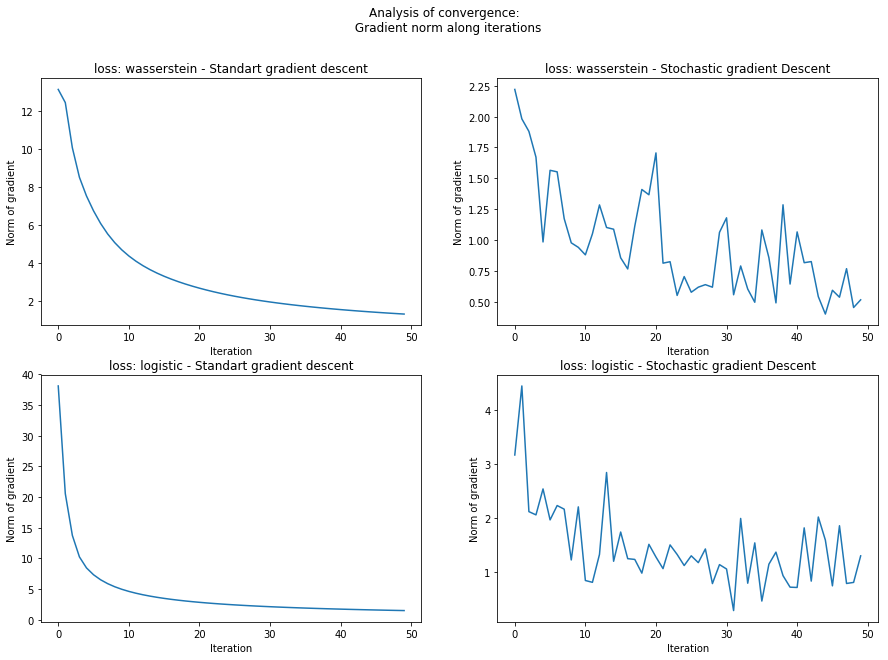

In [6]:
plt.figure(figsize=(15,10))
print('Analysis of prediction : \n confusion matrix')

k = 1
for loss_ in ['wasserstein', 'logistic']:
    for method_ in ['gradient', 'sgd']:
        # train
        clf = predictor(loss = loss_, method = method_, eta = 0.05, n_iter=50)
        clf.train(X,y_score)
        norm_list = [np.linalg.norm(g) for g in clf.grad_list]
        
        # convergence
        plt.subplot(2,2,k).set_title('loss: ' + clf.loss  + ' - '+ clf.methodp())
        plt.plot(norm_list)
        plt.xlabel('Iteration')
        plt.ylabel('Norm of gradient')
        k+=1
        
        # prediction
        print('-----')
        print('loss: ' + clf.loss  + ' - '+ clf.methodp())
        y_score_pred = clf.predict(X)
        y_pred = y_score_pred.argmax(axis = 1)
        print(confusion_matrix(y_pred, y))

plt.suptitle('Analysis of convergence: \n Gradient norm along iterations')
plt.show()

Great ! Only few mistakes in confusion matrix : predictions are good <br>
Futhermore, the convergence seems to be ok.<br>
Now, let's play with this algo on toy dataset...

## III - Iris dataset

** dataset ** <br>

In [7]:
def one_hot_encode(y):
    K = np.unique(y).shape[0]
    y_score = np.array([ [0]*K for i in y])
    for v,i in enumerate(y) :
        y_score[v,i]+= 1
    return y_score

iris = load_iris()
X = iris.data
y = iris.target
y_score = one_hot_encode(y)

#### III.1 - Cheking the good running of the algo

I check again, the good running of the predictor. Now that I am using a more complex dataset, I spend some times to adjust the parameters *eta* and *n_iter* to make it work.

Analysis of prediction : 
 confusion matrix
-----
loss: wasserstein - Standart gradient descent
[[50  0  0]
 [ 0 46  0]
 [ 0  4 50]]
-----
loss: wasserstein - Stochastic gradient Descent
[[50  0  0]
 [ 0 46  0]
 [ 0  4 50]]
-----
loss: logistic - Standart gradient descent
[[50  0  0]
 [ 0 47  0]
 [ 0  3 50]]
-----
loss: logistic - Stochastic gradient Descent
[[50  0  0]
 [ 0 46  0]
 [ 0  4 50]]


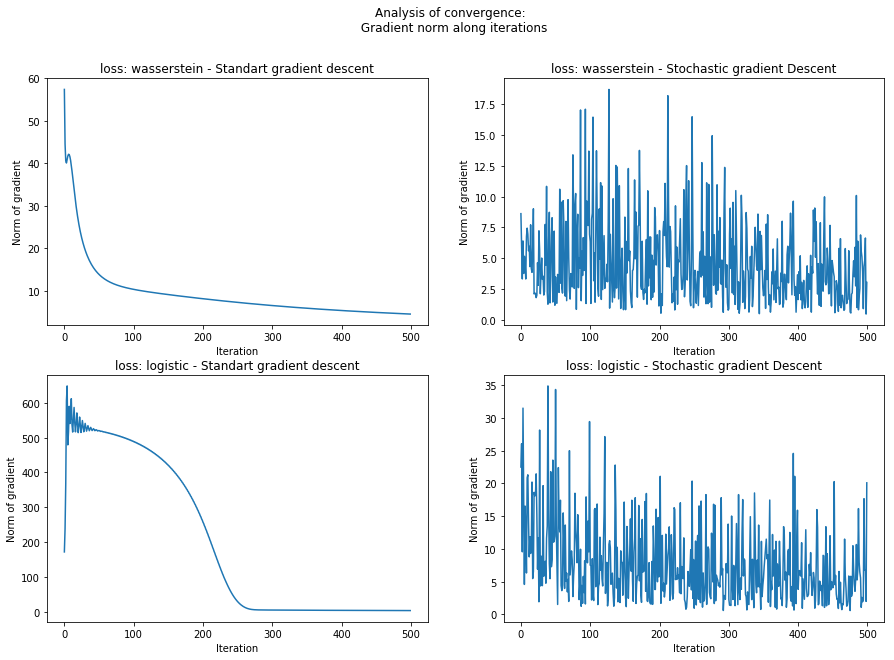

In [8]:
plt.figure(figsize=(15,10))
print('Analysis of prediction : \n confusion matrix')

k = 1
for loss_ in ['wasserstein', 'logistic']:
    for method_ in ['gradient', 'sgd']:
        # train
        clf = predictor(loss = loss_, method = method_, eta = 0.001, n_iter=500, n_sinkhorn=10)
        clf.train(X,y_score)
        norm_list = [np.linalg.norm(g) for g in clf.grad_list]
        
        # convergence
        plt.subplot(2,2,k).set_title('loss: ' + clf.loss  + ' - '+ clf.methodp())
        plt.plot(norm_list)
        plt.xlabel('Iteration')
        plt.ylabel('Norm of gradient')
        k+=1
        
        # prediction
        print('-----')
        print('loss: ' + clf.loss  + ' - '+ clf.methodp())
        y_score_pred = clf.predict(X)
        y_pred = y_score_pred.argmax(axis = 1)
        print(confusion_matrix(y_pred, y))

plt.suptitle('Analysis of convergence: \n Gradient norm along iterations')
plt.show()

#### III.2 - Comparing predictions

Now, I want to compare prediction between the Wasserstein loss and the Logistic loss.<br>
In the figures below, I focus on two features to plot in the 2dimensional space the boundaries of the predictions.

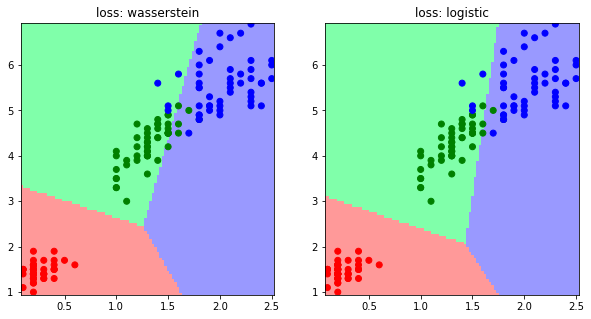

In [9]:
plt.figure(figsize=(10,5))

i = 3
j = 2

x_min, x_max = X[:,i].min(), X[:,i].max()
y_min, y_max = X[:,j].min(), X[:,j].max()

sx = (x_max - x_min)/100
sy = (y_max - y_min)/100

x_min-=sx
x_max+=sx 
y_min-=sy
y_max+=sx

xx, yy = np.meshgrid(np.arange(x_min, x_max+sx, sx),
                     np.arange(y_min, y_max+sy, sy))
k = 1

predictions = {}
for loss_ in ['wasserstein', 'logistic']:

    clf = predictor(loss = loss_, method = 'sgd', eta = 0.001, n_iter=1000, n_sinkhorn=20)
    clf.train(X[:,[i,j]],y_score)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape((xx.shape[0],xx.shape[1],3))

    plt.subplot(1,2,k).set_title('loss: ' + clf.loss)
    predictions[loss_] = Z
    
    plt.pcolormesh(xx, yy, Z.argmax(2), cmap = ListedColormap(['#ff9999', '#80ffaa', '#9999ff']) )
    plt.scatter(X[:,i],X[:,j], c = y, cmap = ListedColormap(list('rgb')))
    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    k+=1
    
plt.show()

Now, I use the *rgb* representation of colored pixel, to visualize $y_{\hbox{score}}$ instead of $y$ as above. <br>
*NB : such a visualisation is impossible with $K > 3$*

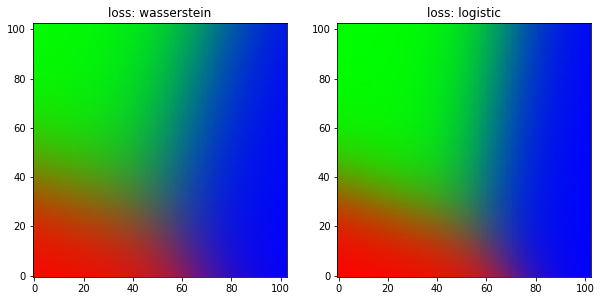

In [10]:
plt.figure(figsize=(10,10))

plt.subplot(1,2,1).set_title('loss: ' + 'wasserstein')
plt.imshow(predictions['wasserstein'])
plt.gca().invert_yaxis()

plt.subplot(1,2,2).set_title('loss: ' + 'logistic')
plt.imshow(predictions['logistic'])
plt.gca().invert_yaxis()

plt.show()

#### III.3 - Changing the ground metric

If I try to modify results with a different metrics $M$ on $\{0,1,2\}$ :

In [11]:
M = np.array([[0,1,2],
              [1,0,1],
              [2,1,0]]) # matrix metrics

clf = predictor(loss = 'wasserstein', method = 'sgd', eta = 0.001, n_iter=1000, n_sinkhorn=20, ground_metric=M)
clf.train(X,y_score)

y_score_pred = clf.predict(X)
y_pred = y_score_pred.argmax(axis = 1)
print(confusion_matrix(y_pred, y))

[[50  0  0]
 [ 0 46  0]
 [ 0  4 50]]


It does not change anything... and this is not suprising ...

In [12]:
M = np.array([[0,1,1],
              [1,0,2],
              [1,2,0]])

clf = predictor(loss = 'wasserstein', method = 'sgd', eta = 0.001, n_iter=1000, n_sinkhorn=20, ground_metric=M)
clf.train(X,y_score)

y_score_pred = clf.predict(X)
y_pred = y_score_pred.argmax(axis = 1)
print(confusion_matrix(y_pred, y))

[[50  0  0]
 [ 0 46  0]
 [ 0  4 50]]


Same comment as above.

On the iris dataset, the differences between Wasserstein loss and the Logistic loss are none. **The Iris dataset is not complex enought to illustrate the benefits to use a Wasserstein loss over a Logistic loss. **

## Take home message

Using a Wasserstein loss is especially relevant when the space of predicted class is provided with a metrics.
The example developped in the paper is particularly relevant. When predicting word tags for pictures, the space of class is a word embedding provided with a metric. The Wasserstein loss allows to take into account this metris in the prediction. A metrics over classes is usefull when you have similarities between class to introduce : when this is not to bad to predict $i$ instead of $j$ because $i$ is almost the same as $j$.